In [4]:
import torch
import os
import numpy as np
import sys
import time
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append("../")
from src.utils import load_processed_data, prepare_dataloaders
from src.model import GRUSurrogate, LSTMSurrogate, TCNForecaster
from src.utils.model_utils import instantiate_model, parse_model_config
from src.utils.train_utils import validation_metrics
from src.utils.config_utils import load_yaml_config

from plot_utils import plot_temperature_sequences

## 1. Load data

In [8]:
run_dir = "/Users/ame/ciceroscm-surrogate/data/20251227_161736"
data_dir = os.path.join(run_dir, "processed")
device = "mps"  # Use MPS for Mac M-series GPU, or "cpu" if MPS not available

# Load and format data
X_train, y_train, X_val, y_val, X_test, y_test, mu, std = load_processed_data(data_dir)
train_loader, val_loader, test_loader, G = prepare_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, mu, std,
                                                               batch_size=512, device=device, num_workers=2)

## 2. Load model

### 2.1 GRU

In [11]:
model_dir = "/Users/ame/ciceroscm-surrogate/data/20251227_161736/training_runs/20251227_171159_gru_128_1"

actual_model_dir = os.path.join(model_dir, "model.pth")
actual_model_dir = Path(actual_model_dir).expanduser()

training_config_path = os.path.join(model_dir, "train_config.yaml")
training_config = load_yaml_config(training_config_path)
model_config = training_config["model"]
device = training_config['general']['device']  # Will use 'mps' from config
model_type, hidden_size, num_layers, kernel_size = parse_model_config(model_config)

# Instantiate model
model = instantiate_model(model_type, G, hidden_size, num_layers, kernel_size=kernel_size, device=device, freeze=False)
model.load_state_dict(torch.load(actual_model_dir, map_location=device, weights_only=False))
model.eval()
# Evaluate model
metrics, y_true, y_pred = validation_metrics(test_loader, model, device, return_predictions=True)

print(f"Test RMSE: {metrics['RMSE']:.5f}, R2: {metrics['R2']:.5f}")

Test RMSE: 0.03563, R2: 0.99296


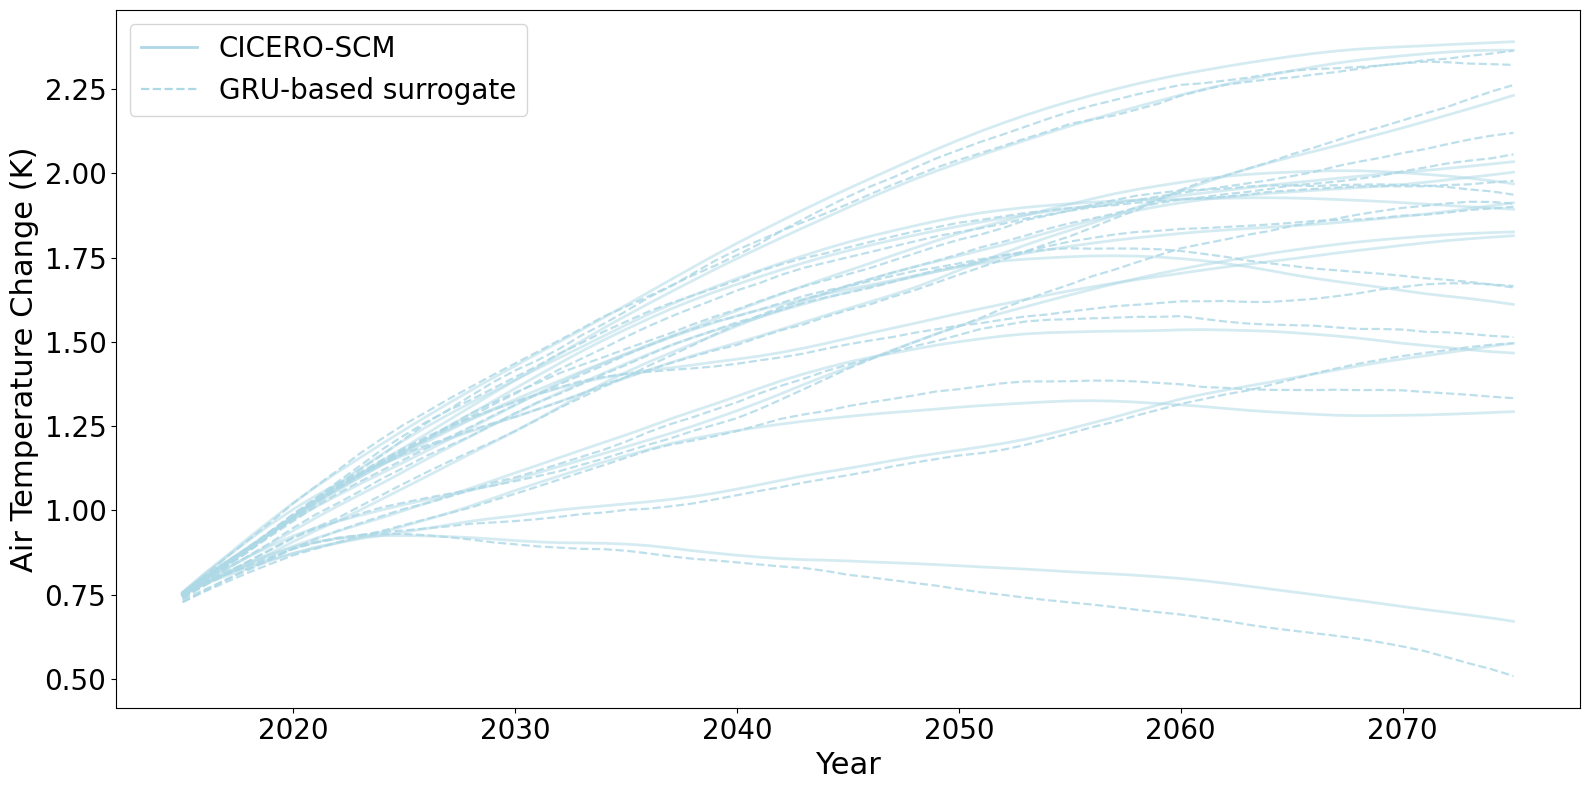

In [12]:
plot_temperature_sequences(y_true, y_pred, seq_len=61, n_samples=75, seed=29,
                   years=np.arange(2015, 2015+36+25), 
                   savepath="plots/test_seq_cicero_vs_gru.pdf", surrogate_name="GRU-based surrogate")

### 2.2 LSTM

In [14]:
model_dir = "/Users/ame/ciceroscm-surrogate/data/20251227_161736/training_runs/20251227_172103_lstm_128_1"

actual_model_dir = os.path.join(model_dir, "model.pth")
actual_model_dir = Path(actual_model_dir).expanduser()

training_config_path = os.path.join(model_dir, "train_config.yaml")
training_config = load_yaml_config(training_config_path)
model_config = training_config["model"]
device = "mps"  # Override device to use Mac MPS instead of CUDA
model_type, hidden_size, num_layers, kernel_size = parse_model_config(model_config)

# Instantiate model
model = instantiate_model(model_type, G, hidden_size, num_layers, kernel_size=kernel_size, device=device, freeze=False)
model.load_state_dict(torch.load(actual_model_dir, map_location=device, weights_only=False))
model.eval()
# Evaluate model
metrics, y_true, y_pred = validation_metrics(test_loader, model, device, return_predictions=True)

print(f"Test RMSE: {metrics['RMSE']:.5f}, R2: {metrics['R2']:.5f}")

Test RMSE: 0.04185, R2: 0.99028


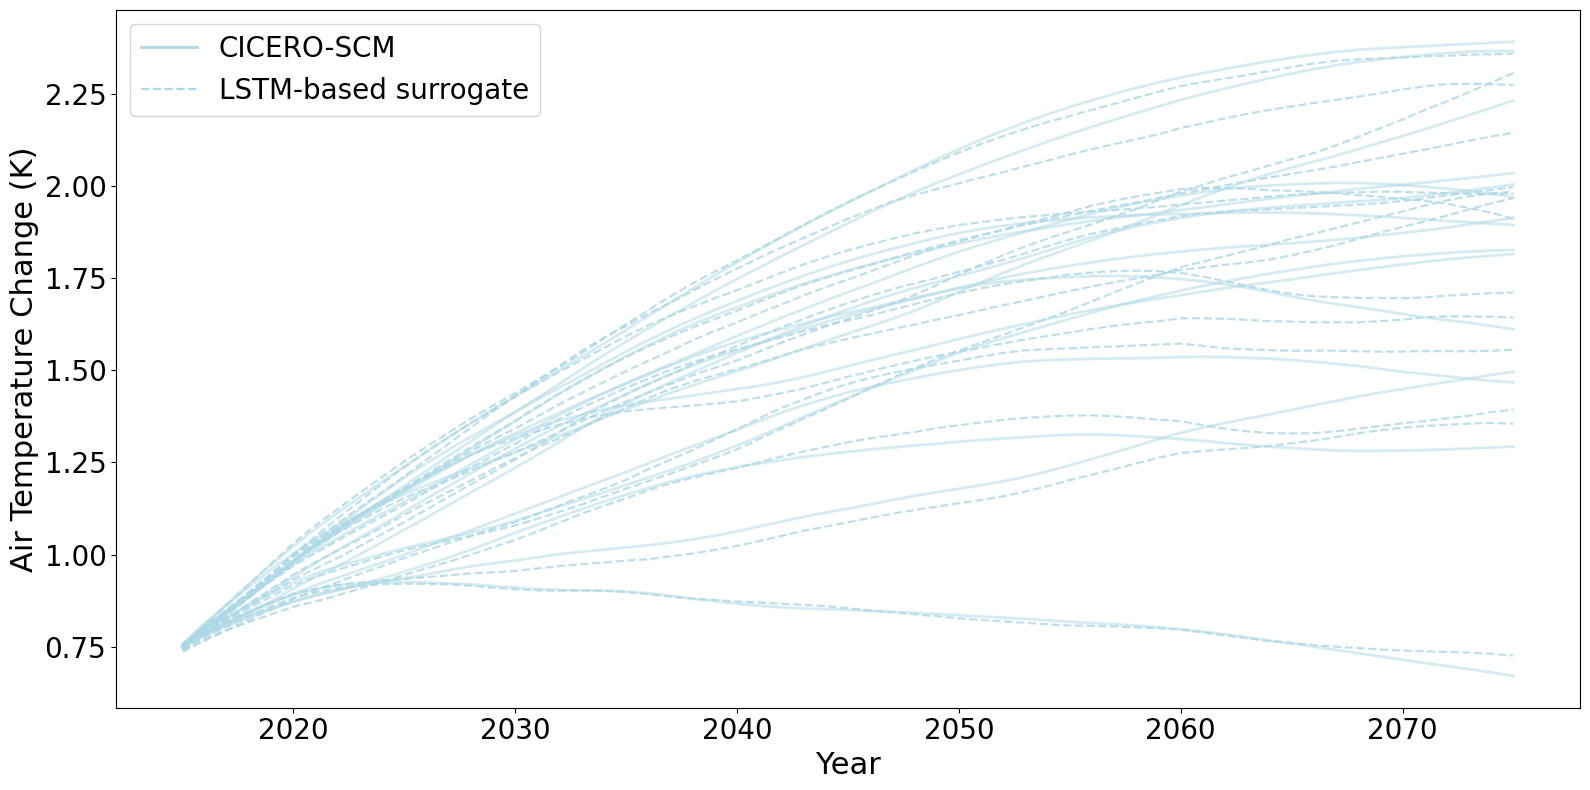

In [15]:
plot_temperature_sequences(y_true, y_pred, seq_len=61, n_samples=75, seed=29,
                   years=np.arange(2015, 2015+36+25), 
                   savepath="plots/test_seq_cicero_vs_lstm.pdf", surrogate_name="LSTM-based surrogate")

### 2.3 TCN

In [20]:
model_dir = "/Users/ame/ciceroscm-surrogate/data/20251227_161736/training_runs/20251227_172356_tcn_128_5"

actual_model_dir = os.path.join(model_dir, "model.pth")
actual_model_dir = Path(actual_model_dir).expanduser()

training_config_path = os.path.join(model_dir, "train_config.yaml")
training_config = load_yaml_config(training_config_path)
model_config = training_config["model"]
device = "mps"  # Override device to use Mac MPS instead of CUDA
model_type, hidden_size, num_layers, kernel_size = parse_model_config(model_config)

# Instantiate model
model = instantiate_model(model_type, G, hidden_size, num_layers, kernel_size=kernel_size, device=device, freeze=False)
model.load_state_dict(torch.load(actual_model_dir, map_location=device, weights_only=False))
model.eval()
# Evaluate model
metrics, y_true, y_pred = validation_metrics(test_loader, model, device, return_predictions=True)

print(f"Test RMSE: {metrics['RMSE']:.5f}, R2: {metrics['R2']:.5f}")

Test RMSE: 0.04274, R2: 0.98986


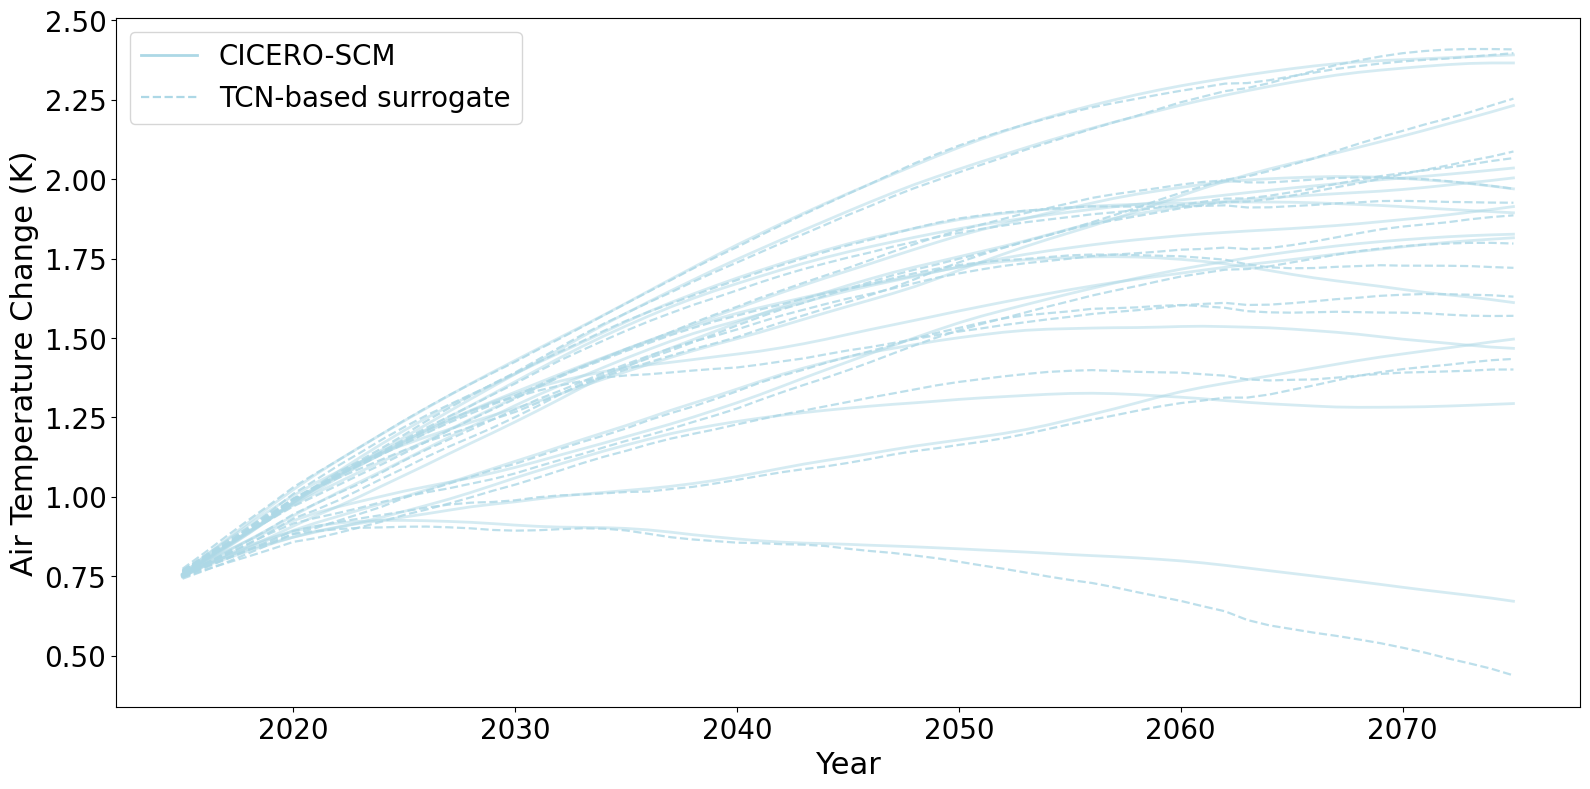

In [21]:
plot_temperature_sequences(y_true, y_pred, seq_len=61, n_samples=75, seed=29,
                   years=np.arange(2015, 2015+36+25), 
                   savepath="plots/test_seq_cicero_vs_tcn.pdf", surrogate_name="TCN-based surrogate")